In [1]:
import os
from glob import glob
import dask
import xarray as xr
import xrft
import cartopy.crs as ccrs
import numpy as np
from netCDF4 import Dataset
from scipy.io import loadmat
import gsw
from cmocean import cm
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster()
    cluster = PBSCluster(cores=6, processes=12) # necessary?
    w = cluster.scale(jobs=8)
    # 3 needed for lagrangian lon/lat binning
    # 15 for eulerian binning
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [3]:
client

Client Scheduler: tcp://10.148.0.39:58322 Dashboard: http://10.148.0.39:8787/status,Cluster Workers: 96 Cores: 384 Memory: 893.76 GiB


________________
## Steric height

In [14]:
out_dir_zarr = '/home1/scratch/xyu/OSMOSIS_llc4320/'
grid_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'

grid = xr.open_dataset(grid_dir_zarr+'Grid.nc', decode_coords=True)
ds_B = xr.open_zarr(grid_dir_zarr+'Buoy_total_rechunk.zarr')

ds = xr.merge([ds_B,grid])

# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(9415))

ds = ds.assign_coords(time=time_day) 
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))
ds.persist()

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates: (12/21)
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
    XC       (lat, lon) float32 ...
    YC       (lat, lon) float32 ...
    ...       ...
    rA       (lat, lon) float32 ...
    rAz      (lat_g, lon_g) float32 ...
    rAw      (lat, lon_g) float32 ...
    rAs      (lat_g, lon) float32 ...
  * lat_g    (lat_g) float32 47.4 47.41 47.42 47.44 ... 49.94 49.96 49.97 49.98
  * lon_g    (lon_g) float32 -18.04 -18.02 -18.0 -17.98 ... -14.42 -14.4 -14.38
Data variables:
    Buoy     (time, depth, lat, lon) float32 dask.array<chunksize=(9415, 1, 1, 177), meta=np.ndarray>

 data size: 69.7 GB


,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(9415, 52, 201, 177)","(9415, 1, 1, 177)"
Count,10452 Tasks,10452 Chunks
Type,float32,numpy.ndarray


In [9]:
steric_height_0_1000 = ds.Buoy.integrate("depth")
steric_height_0_1000.load()

<xarray.DataArray 'Buoy' (time: 9415, lat: 201, lon: 177)>
array([[[-20.93851589, -20.89940703, -20.87582088, ..., -20.8649573 ,
         -20.88127254, -20.90573309],
        [-20.92211369, -20.89256023, -20.8765443 , ..., -20.85158753,
         -20.88029032, -20.9112297 ],
        [-20.90973835, -20.88664683, -20.87650638, ..., -20.8494361 ,
         -20.8885695 , -20.92678271],
        ...,
        [-21.60208331, -21.63476066, -21.66805644, ..., -20.84851121,
         -20.84608328, -20.84105071],
        [-21.591912  , -21.61837523, -21.64725564, ..., -20.8473607 ,
         -20.84464456, -20.83913691],
        [-21.57830075, -21.59968938, -21.62624228, ..., -20.84161622,
         -20.83785547, -20.83140692]],

       [[-20.93549342, -20.91448723, -20.89525417, ..., -20.83985392,
         -20.87486332, -20.91386065],
        [-20.91891411, -20.89808615, -20.88286352, ..., -20.85719739,
         -20.89277228, -20.93403455],
        [-20.90416015, -20.88962245, -20.88211319, ..., -20.87479081,
         -20.90894419, -20.94204852],
...
        [-20.89116271, -20.88056417, -20.87838441, ..., -21.47950819,
         -21.48539999, -21.48978732],
        [-20.9185474 , -20.90761226, -20.90292992, ..., -21.46698394,
         -21.47781689, -21.49184757],
        [-20.9447006 , -20.93221887, -20.92264557, ..., -21.46533577,
         -21.47323668, -21.48724327]],

       [[-20.68349251, -20.64862897, -20.62767327, ..., -20.64130304,
         -20.64608294, -20.62456044],
        [-20.76614927, -20.72074146, -20.67207629, ..., -20.63161235,
         -20.61319487, -20.59294551],
        [-20.78623316, -20.73564785, -20.67150375, ..., -20.62897077,
         -20.59467206, -20.57930716],
        ...,
        [-20.83620541, -20.84214004, -20.84606175, ..., -21.54931888,
         -21.53427611, -21.52386886],
        [-20.84483238, -20.85533911, -20.86567295, ..., -21.54469383,
         -21.53047378, -21.51733019],
        [-20.86644871, -20.8740056 , -20.88666745, ..., -21.54272571,
         -21.52989244, -21.51018917]]])
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
    XC       (lat, lon) float32 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
    YC       (lat, lon) float32 47.4 47.4 47.4 47.4 ... 49.99 49.99 49.99 49.99
    CS       (lat, lon) float32 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    SN       (lat, lon) float32 -2.519e-13 -0.0 -0.0 ... 2.653e-13 -2.652e-13
    Depth    (lat, lon) float32 4.659e+03 4.648e+03 ... 4.07e+03 4.057e+03
    rA       (lat, lon) float32 2.302e+06 2.302e+06 ... 2.09e+06 2.09e+06

In [11]:
sh = -steric_height_0_1000/9.8

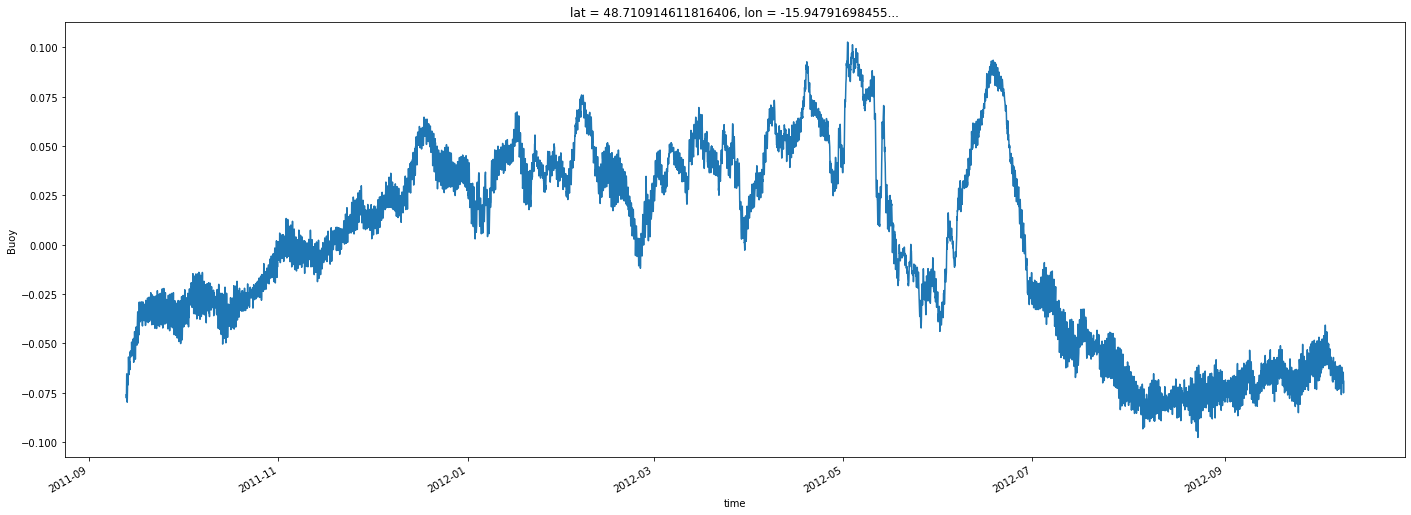

In [12]:
fig = plt.figure(figsize=(24,8))
plt.subplot(111)
(sh - sh.mean('time')).isel(lat=100,lon=100).plot(x='time')

_________
## Glider trajectory

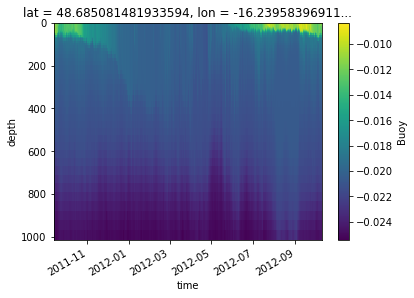

In [17]:
ds.Buoy.sel(lat= 48.6875,lon=-16.25,method='nearest').plot(x='time', y='depth', yincrease=False)

In [ ]:
glider_path = 

In [18]:
cluster.close()